This notebook simulates the spread of a virus via the SIR-model on a network, which is created from an opinion distribution. [Source for the SIR-model: A Contribution to the Mathematical Theory of Epidemics, W. O. Kermack; A. G. McKendrick, 1927]

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

In [84]:
# Load data
data = pd.read_csv("D:\Daten mit Änderungen\Physik\Epidemics_Infodemics_Mobility\Data_repl\HB_u0.2_t1.6.csv", header=None)
data = data.to_numpy()
# Slice off header and index
data = data[1:,1:]

# Set the time at which the virus is to be spread on the network
time_v = 150
data = data[time_v]

# Retrieve number of agents
N = len(data)
# Set threshold with which the network is to be created from the dataset
thresh = 0.1

# Create adjacency matrix
A = np.zeros((N,N), dtype=float)

np.random.seed(42)

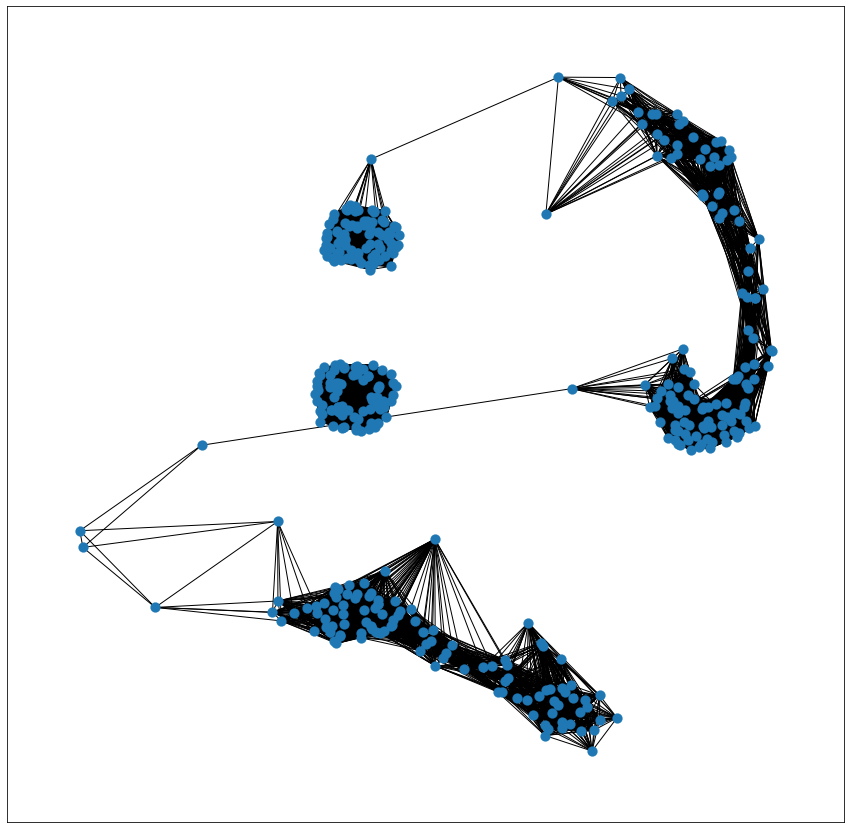

In [85]:
# Fill adjacency matrix with connections between agents
# if their opinion distance is below the threshold
for i in range(N):
    for j in range(i+1,N):
        if abs( data[i]-data[j] ) <= thresh:
            # The connection is not simply 1, since in a network with fully connected cluster
            # where all connections weigh the same a virus spreads much faster than it would
            # in reality. Thus, weve used a powerlaw distribution to weigh the connections,
            # resulting in few very strong connections, i.e. people that have a lot of 
            # contact which leads to a higher infection probability, and many weak connections
            # that in turn yield a lower infection probability between two agents.
            # We added plus one to the matrix since networkx won´t create a graph from the
            # matrix if weights are below 1.
            rand = 2-np.random.power(5.0)
            A[i][j] = rand
            A[j][i] = rand

# Create Graph from adjacency matrix
G = nx.from_numpy_matrix(A)
# Draw network for first overview
pos = nx.spring_layout(G, scale=5.0, weight=None, iterations=15)
plt.figure(figsize=(15,15))
nx.draw_networkx(G, node_size=100, linewidths=0.2, pos=pos, with_labels=False)

In [86]:
# Create the function that performs the SIR-model on the graph G
def SIR(G, beta, gamma, I0, runtime, filename, seed=41):
    # Set seed
    np.random.seed(seed)
    # Retrieve number of agents
    N = len(G.nodes())
    # Create array that saves the state of an agent (susceptible = 0,
    # infected = 1, recovered = 2) and one that contains all indices
    # for setting up I0 random infected agents in the beginning
    state = np.zeros(N, dtype=int)
    inds = np.arange(0, N, dtype=int)
    # Create saving array
    saves = np.zeros((runtime, N))

    # Set first infected
    infs = np.random.choice(inds, I0, replace=False)
    # Update their states
    for i in infs:
        state[i] = 1

    
    # Start dynamics
    t = 0
    while t < runtime:
        # save current states
        saves[t] = state
        # Go through currently infected agents
        for i in infs:
            # Go through neighbors of infected agent i
            for j in G.neighbors(i):
                # Only infect susceptible nodes
                if state[j] == 0:
                    # Only interact if rand is smaller
                    # than the connection strength of i & j
                    rand = np.random.uniform()
                    if rand <= A[i][j]-1:
                        # randomly determine whether she´s infected
                        rand = np.random.uniform()
                        if rand <= beta:
                            state[j] = 1
            # randomly determine whether i recovers
            rand = np.random.uniform()
            if rand <= gamma:
                state[i] = 2

        # update the array of infected agents
        infs = []
        for i in range(N):
            if state[i] == 1:
                infs.append(i)

        t += 1

    # Export saves to csv
    pd.DataFrame(saves).to_csv(f"D:\Daten mit Änderungen\Physik\Epidemics_Infodemics_Mobility\Data_inf\{filename}.csv", header=None, index=None)

    return saves

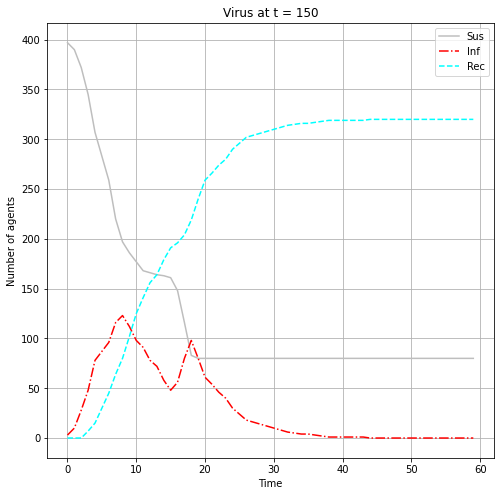

In [87]:
# set parameters
beta = 1/3
gamma = 1/6
I0 = 3
runtime = 60
filename = f"HB_{time_v}"

# Perform simulation
data1 = SIR(G, beta, gamma, I0, runtime, filename)

# retrieve number of susceptible, infected and recovered agents
# from the data for plotting
counts = np.zeros( (len(data1), 3) )
for i in range (len(data1)):
    c0 = 0
    c1 = 0
    c2 = 0
    for j in range (len(data1[i])):
        if data1[i][j] == 0:
            c0 += 1
        elif data1[i][j] == 1:
            c1 += 1
        elif data1[i][j] == 2:
            c2 += 1
    counts[i][0] = c0
    counts[i][1] = c1
    counts[i][2] = c2

# Create figure
time = np.arange(0, len(data1))
plt.figure(figsize=(8,8))
plt.plot(time, counts[:,0], label='Sus', color='#bebebe')
plt.plot(time, counts[:,1], label="Inf", linestyle="dashdot", color="#ff0000")
plt.plot(time, counts[:,2], label="Rec", linestyle="dashed", color='#00ffff')
plt.xlabel("Time")
plt.ylabel("Number of agents")
plt.title(f"Virus at t = {time_v}")
plt.legend()
plt.savefig(f"D:\Daten mit Änderungen\Physik\Epidemics_Infodemics_Mobility\Infs_HB_u0.2_t1.6_{time_v}.png")
plt.grid()
plt.show()

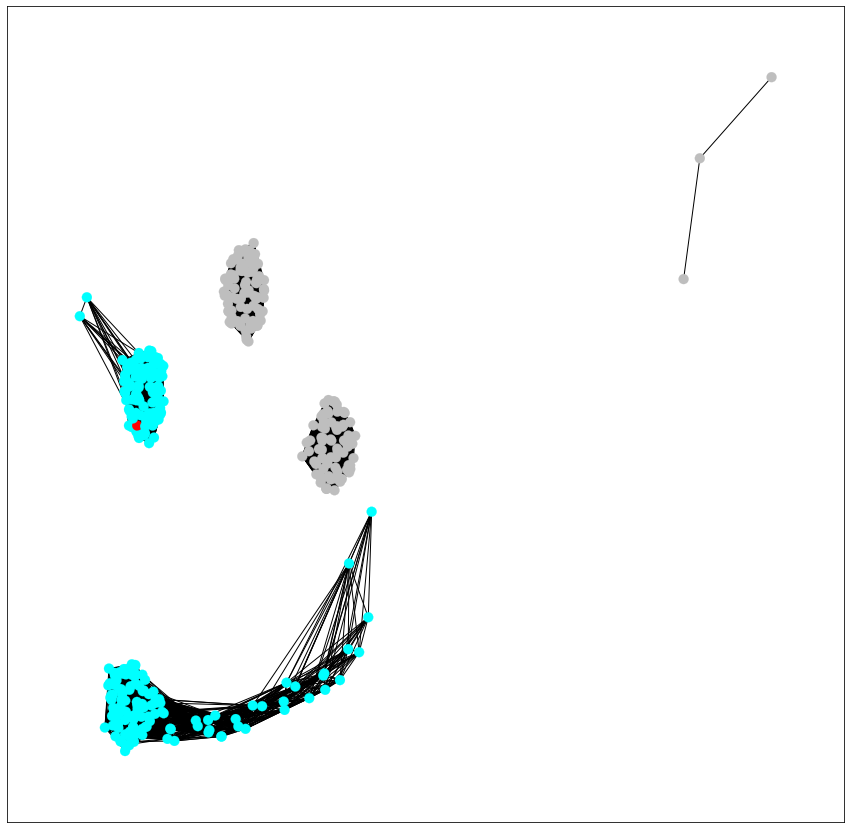

In [79]:
# Create empty list that is filled with the color each node should have in
# the plot of the network. Grey is for susceptible nodes, red for infected
# and green for recovered.
cols = []
# Set iteration step at which the current dynamics are to be plotted.
t = 40
# Fill list of colors
for i in range (len(G.nodes())):
    if data1[t][i] == 0:
        cols.append('#bebebe')
    if data1[t][i] == 1:
        cols.append('#ff0000')
    if data1[t][i] == 2:
        cols.append('#00ffff')

# Plot and save
plt.figure(figsize=(15,15))
nx.draw_networkx(G, node_size=100, linewidths=0.2, pos=pos, with_labels=False, node_color=cols)
plt.savefig(f"D:\Daten mit Änderungen\Physik\Epidemics_Infodemics_Mobility\Infs_HB_u0.2_t1.6_{time_v}_{t}.png")